In [1]:
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from re_forecast.data.manage_data_storage import read_register
from re_forecast.data.get_data import get_rte_units_names, get_rte_data
from re_forecast.preprocessing.check_data_quality import check_data_quality

# Preprocessing

Aims of this notebook :  
- Clean all the datasets non present in the register, used for the developpement of the data package
- Construct a dataset and justify the choice of this dataset
- Formatting the datetime column
- First graphical view of the datas
- Detecting missing values and their number
- Propose methods to deal with missing datas

Bonus : Create a function to check the quality of the datas, such as sufficient row number, proportion of missing values, and missing values gaps

## Clean the datas used for the developpement of the data package

We want to clean all the datas non present in the register.

In [2]:
# Show the register
read_register()

,creation_date,ressource,start_date,end_date,eic_code,production_type,production_subtype,file_name
0,2024-03-12_14:15:18,actual_generations_per_production_type,2022-09-01_00:00:00,2023-09-01_00:00:00,NaN,all-units,NaN,actual_generations_per_production_type__2022-0...
1,2024-03-28_10:37:55,actual_generations_per_unit,2022-06-01_00:00:00,2024-03-01_00:00:00,all-units,NaN,NaN,actual_generations_per_unit__2022-06-01_00:00:...


## Choice of a dataset and download

We will choose a wind generation unit from ressource nb 2 (actual generation per unit), to ensure that the power of the generation assets we looking at does not change over time.

In [3]:
# Show the units names for the ressource nb 2
ressource_nb = 2
actual_generation_per_unit__unit = get_rte_units_names(ressource_nb = ressource_nb)

In [4]:
# Get the production types
actual_generation_per_unit__unit["production_type"].unique()

array(['FOSSIL_GAS', 'WIND_OFFSHORE', 'FOSSIL_HARD_COAL', 'FOSSIL_OIL',
       'HYDRO_RUN_OF_RIVER_AND_POUNDAGE', 'HYDRO_WATER_RESERVOIR',
       'HYDRO_PUMPED_STORAGE', 'NUCLEAR', 'OTHER', 'BIOMASS'],
      dtype=object)

In [5]:
# Display units names and filter for wind generation
wind_production_types = ["WIND_ONSHORE", "WIND_OFFSHORE"]
actual_generation_per_unit__unit.loc[actual_generation_per_unit__unit["production_type"].isin(wind_production_types), :]

,eic_code,name,production_type
3,17W0000014455651,BANC DE GUERANDE 1,WIND_OFFSHORE
4,17W000001445567Y,BANC DE GUERANDE 2,WIND_OFFSHORE
5,17W000001445569U,FECAMP 1,WIND_OFFSHORE
6,17W0000014455708,FECAMP 2,WIND_OFFSHORE
140,17W100P100P0842Y,A1 DE PARC EOLIEN EN MER DE LA BAIE DE ST-BRIEUC,WIND_OFFSHORE
142,17W100P100P3382R,A2 DE PARC EOLIEN EN MER DE LA BAIE DE ST-BRIEUC,WIND_OFFSHORE


Let's try out the 'BANC DE GUERANDE 1' generation unit, as it is the first operationnal wind offshore generation unit in France (https://www.eoliennesenmer.fr/facades-maritimes-en-france/facade-nord-atlantique-manche-ouest/saint-nazaire)

The operationnal start date of the generation unit 'BANC DE GUERANDE 1' can be found here : https://fr.wikipedia.org/wiki/Parc_%C3%A9olien_en_mer_de_Saint-Nazaire#cite_note-3

In [6]:
# Set the params
ressource_nb = 2
start_date = "2022-06-01 00:00:00" # Note: don't modify the start & end date for following requests
end_date = "2024-03-01 00:00:00"
eic_code = "17W0000014455651"
production_type = None
production_subtype = None

# Download: wait 1 hour between each api call
guerande_energy_generation = get_rte_data(ressource_nb = ressource_nb,
                                          start_date = start_date,
                                          end_date = end_date,
                                          eic_code = eic_code,
                                          production_type = production_type,
                                          production_subtype = production_subtype)

In [7]:
guerande_energy_generation

,start_date,end_date,updated_date,value,eic_code
788396,2023-03-03T22:00:00+01:00,2023-03-03T23:00:00+01:00,2023-03-03T23:25:47+01:00,107.0,17W0000014455651
788397,2023-03-03T23:00:00+01:00,2023-03-04T00:00:00+01:00,2023-03-04T00:23:08+01:00,136.0,17W0000014455651
788398,2023-03-04T00:00:00+01:00,2023-03-04T01:00:00+01:00,2023-03-04T01:24:06+01:00,127.0,17W0000014455651
788399,2023-03-04T01:00:00+01:00,2023-03-04T02:00:00+01:00,2023-03-07T14:05:05+01:00,109.0,17W0000014455651
788400,2023-03-04T02:00:00+01:00,2023-03-04T03:00:00+01:00,2023-03-04T03:23:02+01:00,85.0,17W0000014455651
...,...,...,...,...,...
1883021,2024-02-29T19:00:00+01:00,2024-02-29T20:00:00+01:00,2024-02-29T20:26:10+01:00,148.0,17W0000014455651
1883022,2024-02-29T20:00:00+01:00,2024-02-29T21:00:00+01:00,2024-02-29T21:23:57+01:00,190.0,17W0000014455651
1883023,2024-02-29T21:00:00+01:00,2024-02-29T22:00:00+01:00,2024-02-29T22:28:58+01:00,225.0,17W0000014455651
1883024,2024-02-29T22:00:00+01:00,2024-02-29T23:00:00+01:00,2024-02-29T23:24:01+01:00,196.0,17W0000014455651


In [8]:
read_register()

,creation_date,ressource,start_date,end_date,eic_code,production_type,production_subtype,file_name
0,2024-03-12_14:15:18,actual_generations_per_production_type,2022-09-01_00:00:00,2023-09-01_00:00:00,NaN,all-units,NaN,actual_generations_per_production_type__2022-0...
1,2024-03-28_10:37:55,actual_generations_per_unit,2022-06-01_00:00:00,2024-03-01_00:00:00,all-units,NaN,NaN,actual_generations_per_unit__2022-06-01_00:00:...


## Formatting the datetime columns

Inspect the missing values into the datetimes columns :

In [9]:
guerande_energy_generation.isnull().sum()

start_date      0
end_date        0
updated_date    0
value           0
eic_code        0
dtype: int64

Let's try to format one datetime column :

In [10]:
# pd.to_datetime(guerande_energy_generation["start_date"], format = "mixed").sample(10)

In [11]:
# Construct a first function to deal with winter time and summer time
def handle_seasonal_time(date_str: str,
                         winter_time_flag = "+01:00",
                         summer_time_flag = "+02:00",
                         dt_format = "%Y-%m-%dT%H:%M:%S"
                         ) -> datetime.datetime:
    """Transform a date string into datetime object and deal with seasonal
    times. If the seasonal time flag indicate summer time, convert into winter
    time the datetime object by removing one hour.
    Arguments: the date as a string
    - date_str :
    Params:
    - dt_format: datetime format to respect
    - winter/summer_time_flag: The flag at end of date string that indicate winter or summer time"""

    # Ensure that the input in of type 'str'
    if isinstance(date_str, str):

        # If the string end with a winter time flag, rid of the flag and return the
        # datetime object corresponding to the time string
        if date_str.endswith(winter_time_flag):
            date_str = date_str.replace(winter_time_flag, "")

            return datetime.datetime.strptime(date_str, dt_format)

        # If the string end with a summer time flag, rid of the flag and return the
        # datetime object minus one hour corresponding to the time string
        elif date_str.endswith(summer_time_flag):
            date_str = date_str.replace(summer_time_flag, "")

            return datetime.datetime.strptime(date_str, dt_format) - datetime.timedelta(hours = 1)

        # Otherwise, there is an error in the format of the string
        else:
            raise ValueError("Wrong format of the datetime string")

    # If the input is not of type string, the wrong column was selected
    else:
        raise ValueError("Wrong column selected")

# Construct a function to transform str date columns to datetimes columns
def format_to_datetime(gen_df: pd.DataFrame,
                       dt_columns: list
                       ) -> pd.DataFrame:
    """Format to datetime multiple columns of a df among a list of columns.
    Arguments:
    - gen_df: the df which we want to transform the datetime columns
    - dt_columns: a list of names of datetime columns to transform"""

    # /!\ Copy the df
    gen_df_copy = gen_df.copy(deep = True)

    # Iterate over the datetime columns
    for dt_column in dt_columns:
        try:
            # Handle summer and winter time and transform to datetime the column
            gen_df_copy.loc[:, dt_column] = gen_df_copy[dt_column].apply(handle_seasonal_time)

        except ValueError as e:
            print(e)

    return gen_df_copy

In [12]:
# Test the handle seasonal time function
handle_seasonal_time(guerande_energy_generation["start_date"][1314507])

datetime.datetime(2023, 8, 26, 0, 0)

In [13]:
# Set the datetime columns names
dt_columns = ["start_date", "end_date", "updated_date"]

# Test the function
guerande_energy_generation_dt = format_to_datetime(guerande_energy_generation,
                                                   dt_columns = dt_columns)

/tmp/ipykernel_240868/2010205829.py:57: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  gen_df_copy.loc[:, dt_column] = gen_df_copy[dt_column].apply(handle_seasonal_time)


In [14]:
# Check dtypes of the new formated df
display(guerande_energy_generation_dt.dtypes)
display(guerande_energy_generation_dt["start_date"].dtype)
display(type(guerande_energy_generation_dt["start_date"][1843728]))

start_date      datetime64[ns]
end_date        datetime64[ns]
updated_date    datetime64[ns]
value                  float64
eic_code                object
dtype: object

dtype('<M8[ns]')

pandas._libs.tslibs.timestamps.Timestamp

## First visualisation of the data

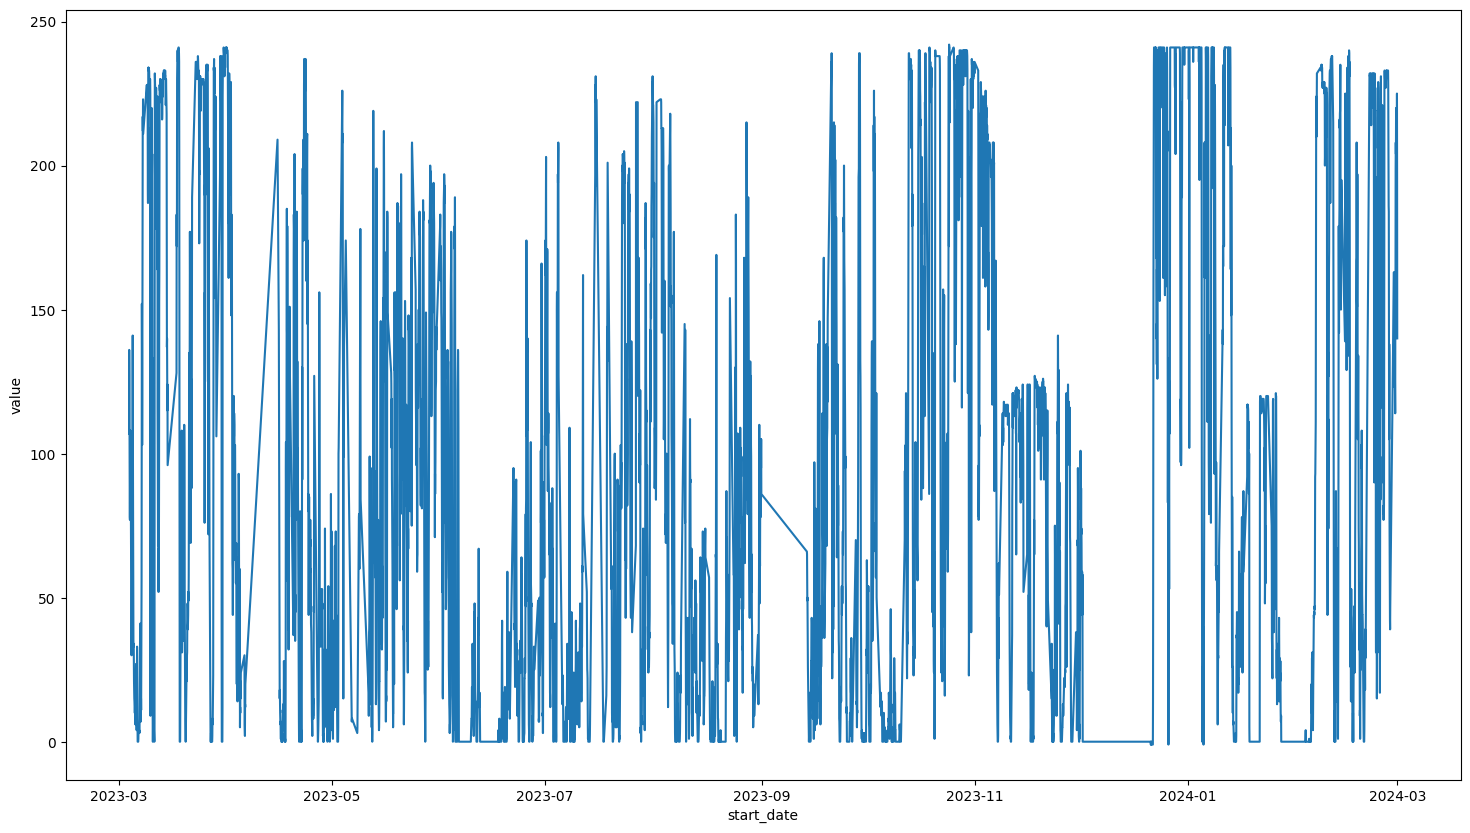

In [15]:
# Line plot
plt.figure(figsize = (18, 10))
sns.lineplot(data = guerande_energy_generation_dt, x = "start_date", y = "value")
plt.show()

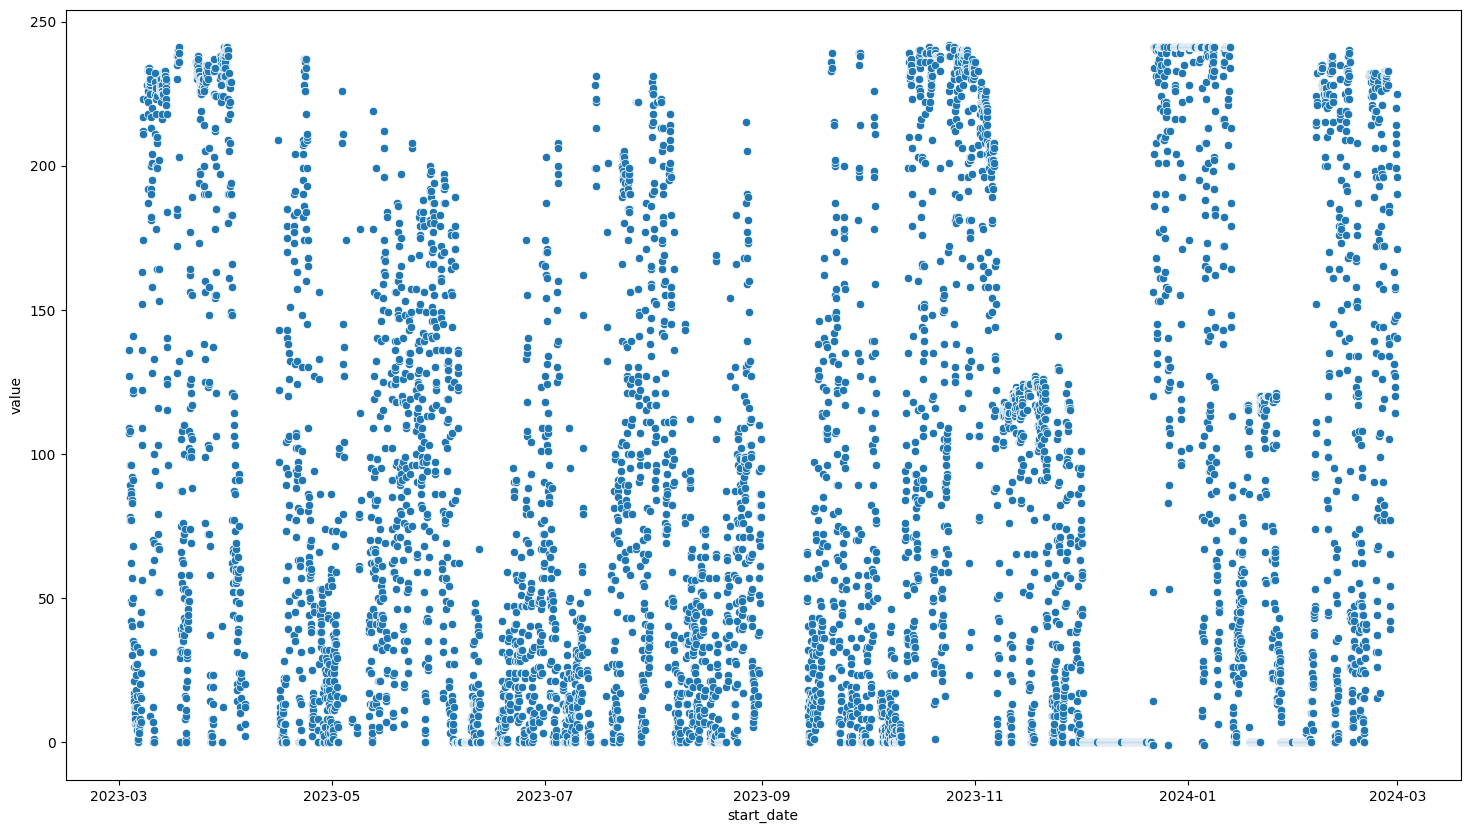

In [16]:
# Scatter plot
plt.figure(figsize = (18, 10))
sns.scatterplot(data = guerande_energy_generation_dt, x = "start_date", y = "value")
plt.show()

We see that some values are 0, meanwhile others values are missing. We saw that there is no 'nan' values inside the dataset, so we conclude that maybe this is some dates that are missing.

Let's see how the data presents in a lower time scale with a plotly graph :

In [17]:
# Plotly line chart
fig = px.line(x = guerande_energy_generation_dt["start_date"], y = guerande_energy_generation_dt["value"])
fig.show()

## Detecting missing values and their number

As we saw earlier, it is plausible that missing values may be missing dates. Because there is no missing values, we are pretty sure that a non empty start_date correspond to a non empty en_date and a non empty updated_date. So we will check the consistency of the start date column. We want the number of missing dates and their placement.

In [18]:
# start = guerande_energy_generation["start_date"].min()
# end = guerande_energy_generation["start_date"].max()
# dt_index = pd.date_range(start, end, freq = "1H")
# date_complete = pd.DataFrame({"start_date_complete": dt_index})
# pd.merge(left = date_complete, right = guerande_energy_generation_dt, left_on = "start_date_complete", right_on = "start_date", how = "left")["start_date"].isnull()
# display(start, end)

In [19]:
# Construct a function check_dates_consistency, that compare a datetime column of a df with a date time serie with complete dates
def construct_time_consistent_df(gen_df: pd.DataFrame,
                                 dt_columns: list, # start_date or/and end_date columns, not updated date column
                                 freq = "1H"
                                 ) -> pd.DataFrame:
    """Merge the given df with a datetime column without missing values.
    The datetime column take the start date from the existing datetime column in the df,
    and the same is done for the end date. You have to specify the datetime column
    of the given df.
    Arguments:
    - gen_df: The df we want to merge with a consistent datetime column
    - dt_columns: the list of datetime columns you want to complete
    Params:
    - freq: time step between each datetime point in order to construct a consistent datetime column"""

    # Instanciate a list "date_cols_complete" to fill wit the names of complete
    # datetime columns. We will use this list for the following merge
    date_cols_complete = []

    # Iterate over the date columns
    for i, date_col in enumerate(dt_columns):
        # 1/ Create the reference datetime serie

        # Collect start and end date of the date col
        start = gen_df[date_col].min()
        end = gen_df[date_col].max()

        # Create the datetime index
        dt_index = pd.date_range(start, end, freq = freq)

        # Create the df of complete dates corresponding to the date_col
        if i == 0:
            date_complete = pd.DataFrame({f"{date_col}_complete": dt_index})

        else:
            date_complete = pd.concat([date_complete, pd.DataFrame({f"{date_col}_complete": dt_index})], axis = 1)

        # Complete the date_cols_complete list
        date_cols_complete.append(f"{date_col}_complete")

    # 2/ Compare the date_complete columns with the choosen date columns in gen_df

    # Merge date_complete df with gen_df
    gen_df = pd.merge(left = date_complete, right = gen_df, left_on = date_cols_complete, right_on = dt_columns, how = "left")

    return gen_df

def check_dates_consistency(gen_df: pd.DataFrame,
                            date_col: str,
                            int_missing_dates = False # Output missing dates indicator as int 0 or 1 if True
                            ) -> pd.DataFrame:
    """Output a df with a complete datetime column, and missing_dates column that
    indicate if the date in the original df is present (False or 0) or missing (True or 1)
    Arguments:
    - gen_df: the df we want to check time consistency (missing dates)
    - date_col: the name of the datetime column we take for reference in time consistency
    Params:
    - int_missing_dates: format the indicator column to int 0 or 1"""

    # Construct a df with complete dates
    gen_complete_df = construct_time_consistent_df(gen_df, [date_col])

    # Return a serie that map every missing date on the complete timeline
    missing_dates = gen_complete_df[date_col].isnull()

    # Case user want the output missing dates indicator as being int 0 or 1
    if int_missing_dates:
        missing_dates = missing_dates.apply(lambda x: 1 if x else 0)

    return pd.DataFrame({f"{date_col}_complete": gen_complete_df[f"{date_col}_complete"],
                         "missing_dates": missing_dates})

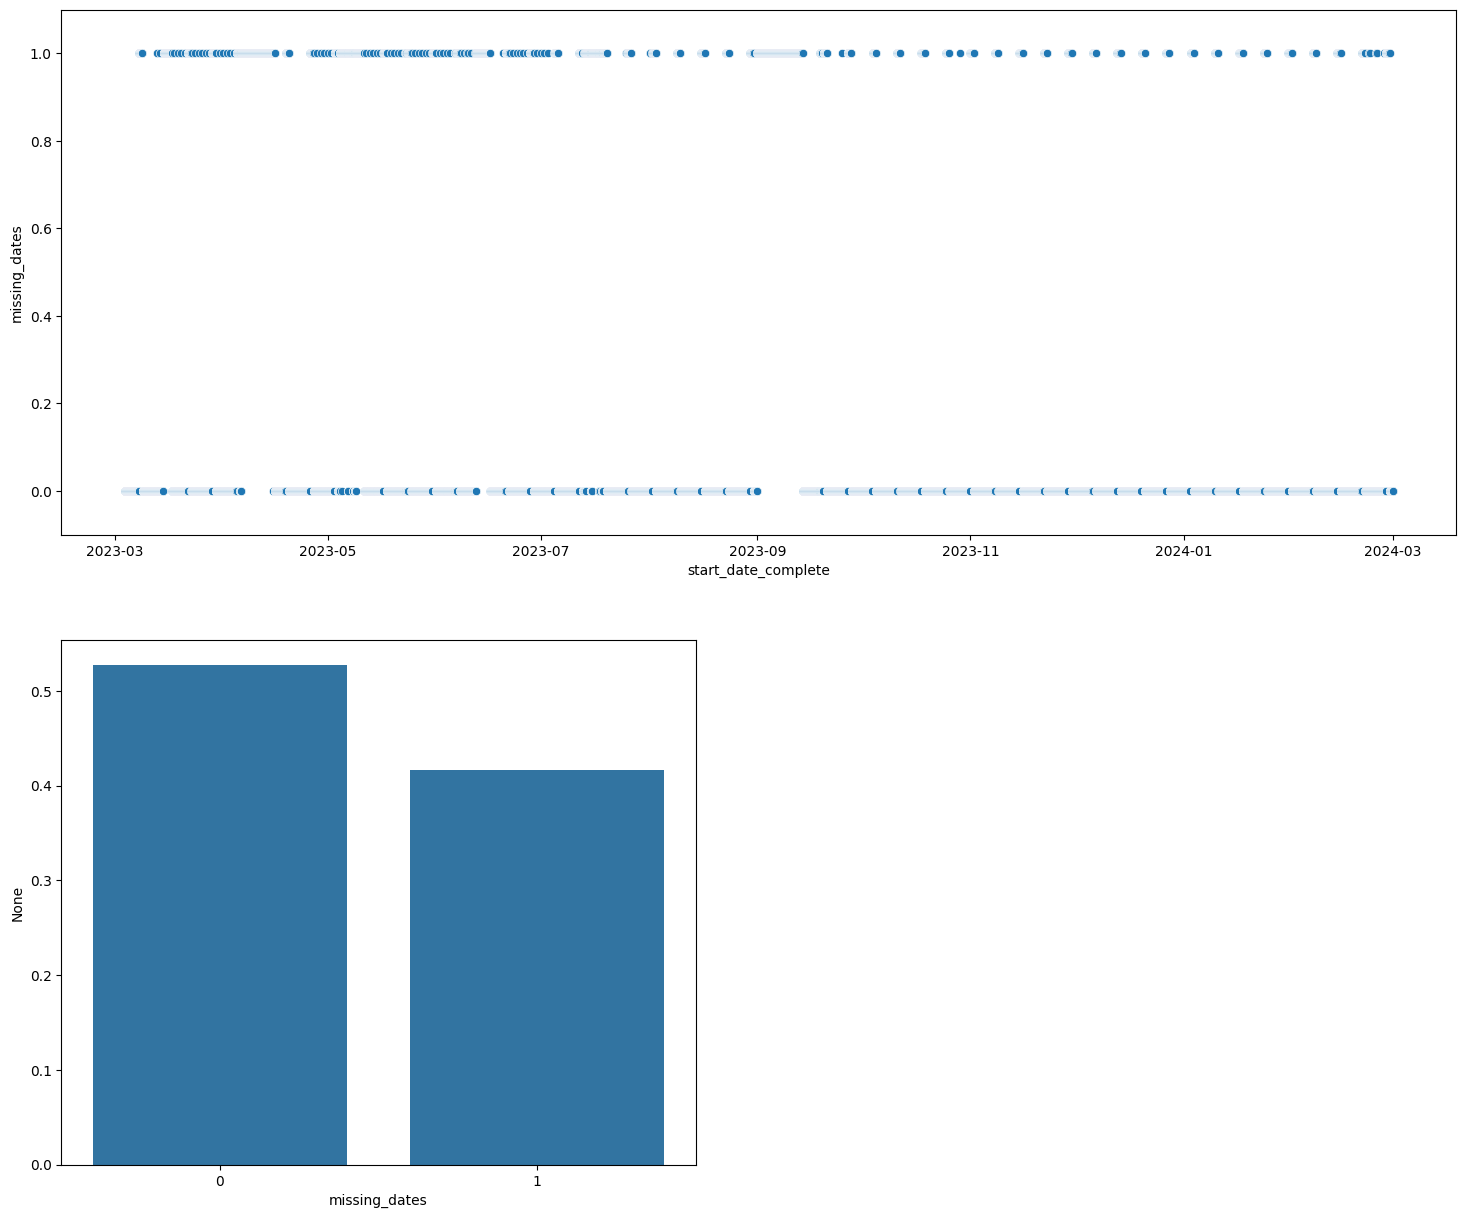

In [20]:
# Test the functions and plot the resulting missing dates
missing_dates_df = check_dates_consistency(guerande_energy_generation_dt,
                                           "start_date",
                                           int_missing_dates = True)

# Plot
plt.figure(figsize = (18, 15))

# Plotting the repartition of missing dates on the timeline
plt.subplot(2, 1, 1)
sns.scatterplot(data = missing_dates_df, x = "start_date_complete", y = "missing_dates")
plt.ylim((-0.1, 1.1))

# Plotting the repartition of missing and non missing datas
plt.subplot(2, 2, 3)
sns.barplot(x = missing_dates_df["missing_dates"], y = missing_dates_df.index / len(missing_dates_df), errorbar = None)

plt.show()

Finally, we want to plot a distribution of the number of consecutive complete time periods, the minimal complete time period and the maximal complete time period.

In [21]:
# display(construct_time_consistent_df(guerande_energy_generation_dt, ["start_date"]).shape)
# display(construct_time_consistent_df(guerande_energy_generation_dt, ["start_date", "end_date"]).isnull().sum())
# construct_time_consistent_df(guerande_energy_generation_dt, ["start_date", "end_date"]).sample(10)

In [22]:
# missing_dates_df = check_dates_consistency(guerande_energy_generation_dt, "start_date", True)
# missing_dates_df["consecutive_group_id"] = missing_dates_df["missing_dates"].diff().ne(0).cumsum()
# missing_dates_df.tail(50)
# display(missing_dates_df.groupby("consecutive_group_id")["missing_dates"].min().to_frame(name = "value"))
# display(missing_dates_df.groupby("consecutive_group_id")["missing_dates"].count().rename("count"))

In [23]:
# Construct the count consecutive time periods function
def plot_consecutive_time_periods(gen_df: pd.DataFrame,
                                        date_col: str
                                        ) -> None:
    """Plot the distribution of consecutive time periods for missing and non
    missing dates of the given df, for its given datetime column.
    Arguments:
    - gen_df: dataframe with a datetime column
    - date_col: the name of the datetime column"""

    # Create the missing dates df
    missing_dates_df = check_dates_consistency(gen_df,
                                               date_col,
                                               int_missing_dates = True)

    # Add the column that give each "0" or "1" cluster an unique id
    # The diff method check the diffence with the previous row
    # The ne method output true when the difference is not 0
    # The cumsum method is just a cumulative sum
    missing_dates_df["consecutive_group_id"] = missing_dates_df["missing_dates"].diff().ne(0).cumsum()

    # Create the consecutive time periods df
    # This df show what is the consecutive value of each group/cluster
    consecutive_time_periods_df = missing_dates_df\
        .groupby("consecutive_group_id")["missing_dates"]\
        .min().to_frame(name = "value")

    # We create a serie that compute the number of consecutive values in each group/cluster
    value_count = missing_dates_df.groupby("consecutive_group_id")["missing_dates"].count().rename("count")

    # Join the serie and the consecutive time periods df
    consecutive_time_periods_df = consecutive_time_periods_df.join(value_count)

    # Filter for missing and non missing dates
    consecutive_missing_dates = consecutive_time_periods_df\
        .loc[consecutive_time_periods_df["value"] == 1, "count"].to_list() # "1" correspond to missing dates
    consecutive_non_missing_dates = consecutive_time_periods_df\
        .loc[consecutive_time_periods_df["value"] == 0, "count"].to_list() # "0" correspond to non missing dates

    # Plot the result
    plt.figure(figsize = (18, 10))

    # Plot repartition of missing dates
    ax = plt.subplot(1, 2, 1)
    ax.set_title("Consecutive missing dates")
    ax.set_xlabel("Duration of consecutive missing date in hour")
    sns.histplot(x = consecutive_missing_dates, ax = ax)

    # Plot the repartition of non missing dates
    ax = plt.subplot(1, 2, 2)
    ax.set_title("Consecutive non missing dates")
    ax.set_xlabel("Duration of consecutive non missing date in hour")
    sns.histplot(x = consecutive_non_missing_dates, ax = ax)

    plt.show()

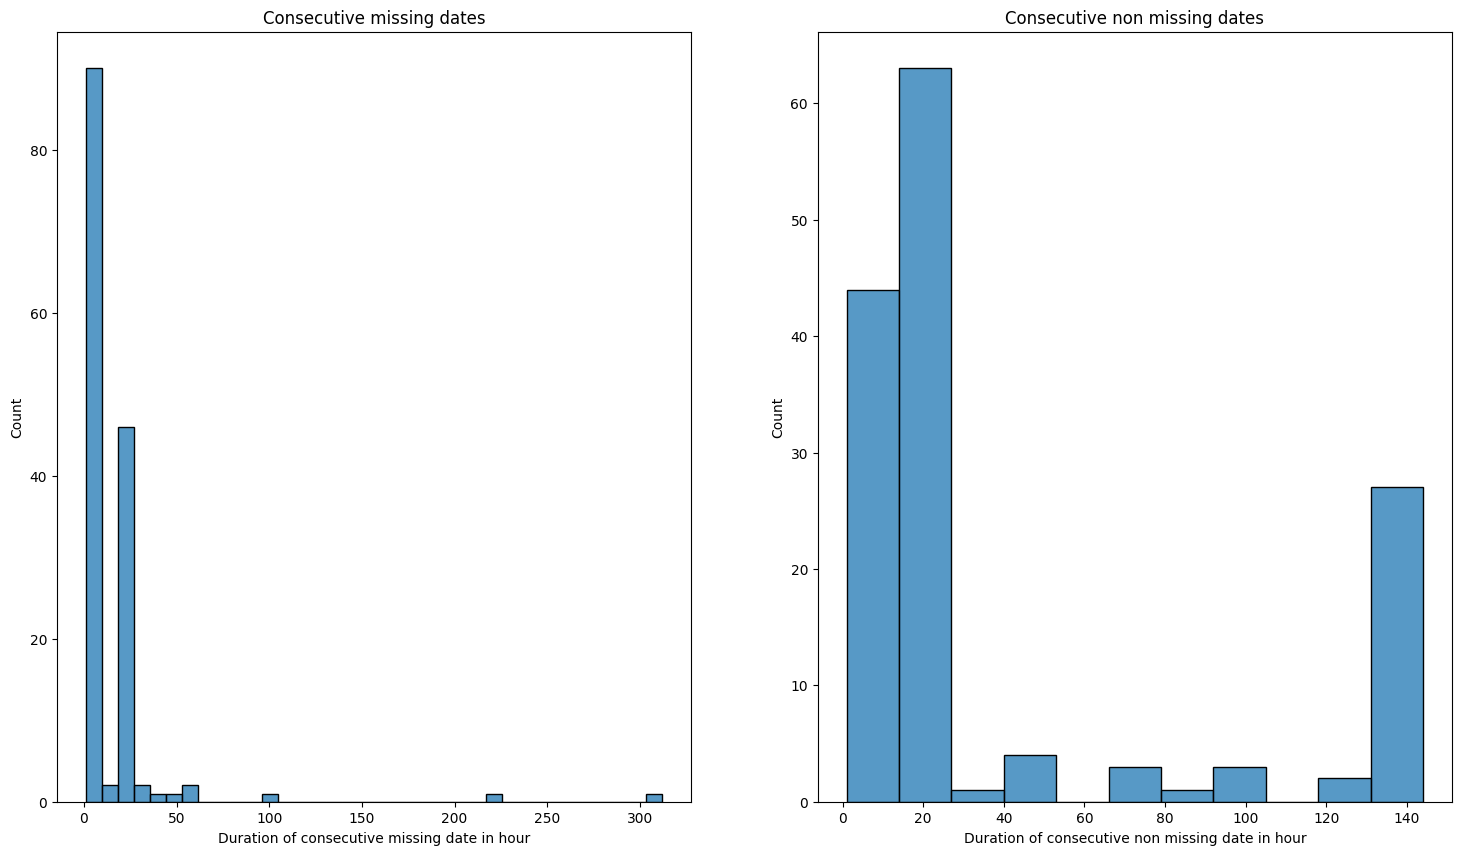

In [24]:
# Test the function
plot_consecutive_time_periods(guerande_energy_generation_dt, "start_date")

## Create the check_data_quality function, to test the quality of the dataset on the numnber of rows, the proportion of missing values and the duration of missing values gaps

In [25]:
check_data_quality(guerande_energy_generation, "start_date")

(False, 'Max empty values gap duration above 50 hours')